<h3> Let us move to Germany </h3>

Import Python packages necessary to data processing, such as numpy and pandas, as well as json  and folium to manage maps and sci-kit learn library  for machine learning methods.

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
#!conda update -n base -c defaults conda


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    li

Explore the dataset <i>Monaco.csv</i> , created manually with geospatial coordinates:
- discover the structure of the dataset

In [117]:
df=pd.read_csv('Monaco.csv', delimiter=';', header=0)
df.head()

,PostalCode,Borough,Latitude,Longitude
0,80331,Altstadt-Lehel,48.143765,11.563515
1,80335,Ludwigsvorstadt-Isarvorstadt,48.130778,11.548124
2,80333,Maxvorstadt,48.148909,11.545498
3,80796,SchwabingWest,48.166652,11.552057
4,81541,Au-Haidausen,48.130288,11.576887


- count number of boroughs in the city

In [172]:
df.shape
print('Munich has {} boroughs'.format(
        len(df['Borough'].unique())
    )
)

Munich has 25 boroughs


- exploiting Folium, create a map of the city of Munich with borough superimposed

In [116]:
address = 'Munich, DE'

geolocator = Nominatim(user_agent="muc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Munich are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Munich are 48.1371079, 11.5753822.


In [112]:
# create map using latitude and longitude values

map_Munich = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
      [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Munich)  
    
map_Munich

Connect the data to Foursquare API to start exploring the city

In [14]:
CLIENT_ID = 'YHIHTB2ZFNRG0DMWPKR2QY4YVRM1GQPTC0DFFJ3NQLRCR3SS' 
CLIENT_SECRET = 'K3SAZTMZZVN0SRMAMQQJAOHDR2QX5CFFZ0G1CPPVTBKULZAW' 
VERSION = '20180605' 

For each of the boroughs, explore which are considered the top venues in a radius of 500m

In [173]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

List Munich's boroughs

In [174]:
LIMIT= 10;
munich_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                   )

Altstadt-Lehel
Ludwigsvorstadt-Isarvorstadt
Maxvorstadt
SchwabingWest
Au-Haidausen
Sendling
Sendling-Westpark
Schwanthalerhoehe
Neuhausen-Nymphenburg
Moosach
Milbertshofen-AmHart
Schwabing-Freimann
Bogenhausen
Berg am Laim
Trudering-Riem
Ramersdorf-Perlach
Obergiesing
Untergiesing-Harlaching
Thalkirchen-Obersendling-Forstenried-Solln
Hadern
Pasing-Obermenzing
Aubing-Lochhausen-Langwied
Allach-Untermenzing
Feldmoching-Hasenbergl
Laim


For each borough, list the top venues (and print the first ones to have an idea of the structure). In total, 170 venues have been found.

In [175]:
print(munich_venues.shape)
munich_venues.head()

(168, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Altstadt-Lehel,48.143765,11.563515,The Charles Hotel,48.142935,11.562526,Hotel
1,Altstadt-Lehel,48.143765,11.563515,Königsplatz,48.145903,11.565099,Plaza
2,Altstadt-Lehel,48.143765,11.563515,Sophia's,48.142795,11.562438,Italian Restaurant
3,Altstadt-Lehel,48.143765,11.563515,Hans im Glück - Burgergrill,48.143983,11.562764,Burger Joint
4,Altstadt-Lehel,48.143765,11.563515,Noppakao,48.143883,11.559871,Thai Restaurant


Sort boroughs based on quantity of top venues

In [176]:
MucVen=munich_venues.groupby('Borough').count()
MucVen['Venue'].sort_values(ascending=False)

Borough
Untergiesing-Harlaching                       10
Schwanthalerhoehe                             10
Ludwigsvorstadt-Isarvorstadt                  10
Maxvorstadt                                   10
Au-Haidausen                                  10
Berg am Laim                                  10
Sendling                                      10
Sendling-Westpark                             10
Altstadt-Lehel                                10
Schwabing-Freimann                             8
Obergiesing                                    8
Trudering-Riem                                 8
Milbertshofen-AmHart                           7
SchwabingWest                                  6
Ramersdorf-Perlach                             6
Bogenhausen                                    5
Aubing-Lochhausen-Langwied                     4
Moosach                                        4
Laim                                           4
Neuhausen-Nymphenburg                          4
Pasing-Oberm

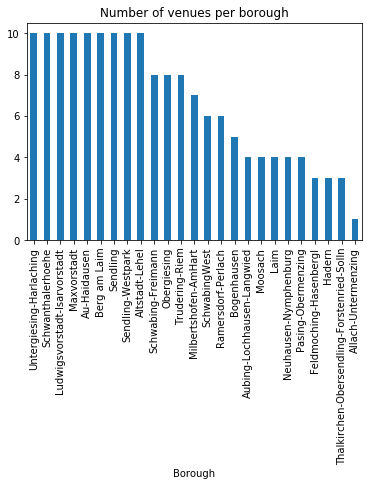

In [29]:
TopVenuesMuc=MucVen['Venue'].sort_values(ascending=False)
TopVenuesMuc.plot.bar(x='Borough', y='Venue', title='Number of venues per borough')

Now, explore each borough to find out which are the top listed venues according to Foursquare categories.
This is done using dummy variables that code categories into 0/1.

In [30]:
# one hot encoding
munich_onehot = pd.get_dummies(munich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
munich_onehot['Borough'] = munich_venues['Borough'] 
# move neighborhood column to the first column
fixed_columns = [munich_onehot.columns[-1]] + list(munich_onehot.columns[:-1])
munich_onehot = munich_onehot[fixed_columns]
munich_onehot.head()

,Borough,Afghan Restaurant,American Restaurant,Art Museum,Arts & Entertainment,Asian Restaurant,Bakery,Bar,Bavarian Restaurant,Beach Bar,Beer Garden,Board Shop,Botanical Garden,Burger Joint,Bus Line,Bus Stop,Café,Canal,Church,Climbing Gym,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Doner Restaurant,Drugstore,Fish Market,Food & Drink Shop,Fountain,Gastropub,German Restaurant,Gym,Gym / Fitness Center,Hill,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Lake,Laser Tag,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Market,Massage Studio,Metro Station,Middle Eastern Restaurant,Modern Greek Restaurant,Monument / Landmark,Museum,Outdoor Sculpture,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Racetrack,Rest Area,Salad Place,Shopping Mall,Soccer Field,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vietnamese Restaurant
0,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [177]:
munich_grouped = munich_onehot.groupby('Borough').mean().reset_index()
munich_grouped

,Borough,Afghan Restaurant,American Restaurant,Art Museum,Arts & Entertainment,Asian Restaurant,Bakery,Bar,Bavarian Restaurant,Beach Bar,Beer Garden,Board Shop,Botanical Garden,Burger Joint,Bus Line,Bus Stop,Café,Canal,Church,Climbing Gym,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Doner Restaurant,Drugstore,Fish Market,Food & Drink Shop,Fountain,Gastropub,German Restaurant,Gym,Gym / Fitness Center,Hill,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Lake,Laser Tag,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Market,Massage Studio,Metro Station,Middle Eastern Restaurant,Modern Greek Restaurant,Monument / Landmark,Museum,Outdoor Sculpture,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Racetrack,Rest Area,Salad Place,Shopping Mall,Soccer Field,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vietnamese Restaurant
0,Allach-Untermenzing,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,1.0,0.0,0.000,0.000000,0.000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.00,0.0,0.00,0.000000,0.00,0.000,0.0,0.000000,0.0,0.0,0.0,0.000,0.000000,0.0,0.0
1,Altstadt-Lehel,0.0,0.0,0.1,0.000000,0.1,0.000,0.1,0.0,0.0,0.000,0.0,0.0,0.1,0.000,0.000000,0.000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000,0.000000,0.00,0.0,0.000000,0.1,0.100000,0.0,0.000000,0.1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.1,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.00,0.1,0.0,0.00,0.000000,0.00,0.0,0.00,0.000000,0.00,0.000,0.0,0.000000,0.0,0.0,0.1,0.000,0.000000,0.0,0.0
2,Au-Haidausen,0.1,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000,0.1,0.0,0.0,0.000,0.000000,0.300,0.00,0.000000,0.0,0.1,0.1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00,0.1,0.00,0.1,0.0,0.00,0.000000,0.00,0.0,0.00,0.000000,0.00,0.000,0.0,0.000000,0.0,0.1,0.0,0.000,0.000000,0.0,0.0
3,Aubing-Lochhausen-Langwied,0.0,0.0,0.0,0.000000,0.0,0.250,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000000,0.000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.25,0.0,0.0,0.00,0.000000,0.00,0.0,0.25,0.000000,0.00,0.000,0.0,0.250000,0.0,0.0,0.0,0.000,0.000000,0.0,0.0
4,Berg am Laim,0.0,0.0,0.0,0.000000,0.0,0.000,0.1,0.0,0.1,0.000,0.0,0.0,0.0,0.000,0.000000,0.000,0.00,0.000000,0.2,0.0,0.0,0.0,0.000000,0.0,0.100000,0.1,0.0,0.00,0.000,0.100000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.1,0.00,0.000000,0.00,0.0,0.00,0.000000,0.00,0.000,0.0,0.100000,0.0,0.0,0.1,0.000,0.000000,0.0,0.0
5,Bogenhausen,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.400000,0.000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,0.00,0.000000,0.0,0.400000,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.00,0.0,0.00,0.000000,0.00,0.000,0.0,0.000000,0.0,0.0,0.0,0.000,0.200000,0.0,0.0
6,Feldmoching-Hasenbergl,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000000,0.000,0.00,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.00,0.000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.

Now it is possible to have an overwview of each borough together with the top venues and create a table listing the top 10 locations for each borough.

In [178]:
num_top_venues = 5
for hood in munich_grouped['Borough']:
    print("----"+hood+"----")
    temp = munich_grouped[munich_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allach-Untermenzing----
               venue  freq
0   Botanical Garden   1.0
1  Afghan Restaurant   0.0
2              Plaza   0.0
3        Pizza Place   0.0
4           Pharmacy   0.0


----Altstadt-Lehel----
                       venue  freq
0               Burger Joint   0.1
1            Thai Restaurant   0.1
2             History Museum   0.1
3                      Hotel   0.1
4  Middle Eastern Restaurant   0.1


----Au-Haidausen----
               venue  freq
0               Café   0.3
1  Afghan Restaurant   0.1
2         Board Shop   0.1
3        Pizza Place   0.1
4              Plaza   0.1


----Aubing-Lochhausen-Langwied----
               venue  freq
0             Bakery  0.25
1      Shopping Mall  0.25
2        Supermarket  0.25
3         Playground  0.25
4  Afghan Restaurant  0.00


----Berg am Laim----
             venue  freq
0     Climbing Gym   0.2
1      Fish Market   0.1
2       Poke Place   0.1
3  Thai Restaurant   0.1
4              Bar   0.1


----Bogenhausen-

In [179]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [180]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = munich_grouped['Borough']

for ind in np.arange(munich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(munich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allach-Untermenzing,Botanical Garden,Vietnamese Restaurant,Fountain,Concert Hall,Convenience Store,Doner Restaurant,Drugstore,Fish Market,Food & Drink Shop,Gastropub
1,Altstadt-Lehel,Italian Restaurant,Hotel,Art Museum,Thai Restaurant,History Museum,Asian Restaurant,Bar,Plaza,Middle Eastern Restaurant,Burger Joint
2,Au-Haidausen,Café,Afghan Restaurant,Board Shop,Coffee Shop,Cocktail Bar,Plaza,Pizza Place,Tea Room,Bakery,Fountain
3,Aubing-Lochhausen-Langwied,Shopping Mall,Playground,Bakery,Supermarket,Vietnamese Restaurant,Coffee Shop,Concert Hall,Convenience Store,Doner Restaurant,Drugstore
4,Berg am Laim,Climbing Gym,Supermarket,Poke Place,Drugstore,Fish Market,German Restaurant,Bar,Beach Bar,Thai Restaurant,Gym
5,Bogenhausen,Park,Bus Stop,Trattoria/Osteria,Vietnamese Restaurant,Food & Drink Shop,Concert Hall,Convenience Store,Doner Restaurant,Drugstore,Fish Market
6,Feldmoching-Hasenbergl,Convenience Store,Racetrack,Lottery Retailer,Vietnamese Restaurant,Food & Drink Shop,Coffee Shop,Concert Hall,Doner Restaurant,Drugstore,Fish Market
7,Hadern,Bus Stop,Massage Studio,Vietnamese Restaurant,Fountain,Concert Hall,Convenience Store,Doner Restaurant,Drugstore,Fish Market,Food & Drink Shop
8,Laim,Park,Playground,Pub,Bus Stop,Fish Market,Coffee Shop,Concert Hall,Convenience Store,Doner Restaurant,Drugstore
9,Ludwigsvorstadt-Isarvorstadt,Juice Bar,German Restaurant,Outdoor Sculpture,Museum,Concert Hall,Doner Restaurant,Salad Place,Park,Bar,Asian Restaurant


<h2> Which boroughs are best for Italians? </h2>
It is now possibile to approach our problem, selecting the top 5 interesting venues for italians.

In [181]:
AllVenues=fixed_columns[1::]
#AllVenues

First of all, a score is computed for each borough to select which ones have more interesting venues.

In [182]:
muc_for_it=munich_grouped[['Borough','Bar','Café','Soccer Field','Trattoria/Osteria','Italian Restaurant','Pizza Place','Fish Market','Ice Cream Shop','Cocktail Bar','Supermarket']]
muc_for_it

,Borough,Bar,Café,Soccer Field,Trattoria/Osteria,Italian Restaurant,Pizza Place,Fish Market,Ice Cream Shop,Cocktail Bar,Supermarket
0,Allach-Untermenzing,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,Altstadt-Lehel,0.1,0.000,0.000000,0.000000,0.1,0.0,0.0,0.0,0.0,0.000000
2,Au-Haidausen,0.0,0.300,0.000000,0.000000,0.0,0.1,0.0,0.0,0.1,0.000000
3,Aubing-Lochhausen-Langwied,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000
4,Berg am Laim,0.1,0.000,0.000000,0.000000,0.0,0.0,0.1,0.0,0.0,0.100000
5,Bogenhausen,0.0,0.000,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.000000
6,Feldmoching-Hasenbergl,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
7,Hadern,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
8,Laim,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
9,Ludwigsvorstadt-Isarvorstadt,0.1,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


It is possibile to visualize how the interesting category are distributed.

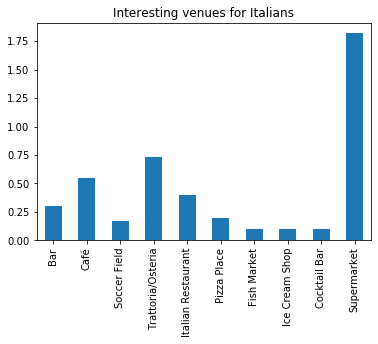

In [195]:
best_italian_venues=muc_for_it.sum(0)
best_italian_venues=best_italian_venues[1:]
best_italian_venues
best_italian_venues.plot.bar(title='Interesting venues for Italians')

It is now possibile to sort the borough based on the computed index, and find out the best 5 boroughs for italians.

In [197]:
sum_best_italian_venues=muc_for_it.sum(1)
top_italian_district=pd.DataFrame([muc_for_it.Borough, sum_best_italian_venues]).T
top_italian_district.rename(columns = {'Unnamed 0':'Score'}, inplace = True) 
top_italian_district

,Borough,Score
0,Allach-Untermenzing,0
1,Altstadt-Lehel,0.2
2,Au-Haidausen,0.5
3,Aubing-Lochhausen-Langwied,0.25
4,Berg am Laim,0.3
5,Bogenhausen,0.2
6,Feldmoching-Hasenbergl,0
7,Hadern,0
8,Laim,0
9,Ludwigsvorstadt-Isarvorstadt,0.1


In [198]:
top_italian_district=top_italian_district.sort_values('Score', ascending=False)
top_for_italians=top_italian_district[0:5]
top_for_italians

,Borough,Score
2,Au-Haidausen,0.5
23,Trudering-Riem,0.5
17,Schwabing-Freimann,0.5
10,Maxvorstadt,0.4
4,Berg am Laim,0.3


For each borough, the top 5 categories of venues are retreived.

In [186]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
it_venues_sorted = pd.DataFrame(columns=columns)
it_venues_sorted['Borough'] = muc_for_it['Borough']

for ind in np.arange(muc_for_it.shape[0]):
    it_venues_sorted.iloc[ind, 1:] = return_most_common_venues(muc_for_it.iloc[ind, :], num_top_venues)


In [199]:
Borough_italians
Borough_italians.loc[[2, 23, 17, 10, 4],:] 

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Au-Haidausen,Café,Cocktail Bar,Pizza Place,Supermarket,Ice Cream Shop
23,Trudering-Riem,Supermarket,Cocktail Bar,Ice Cream Shop,Fish Market,Pizza Place
17,Schwabing-Freimann,Supermarket,Trattoria/Osteria,Café,Cocktail Bar,Ice Cream Shop
10,Maxvorstadt,Italian Restaurant,Pizza Place,Trattoria/Osteria,Supermarket,Cocktail Bar
4,Berg am Laim,Supermarket,Fish Market,Bar,Cocktail Bar,Ice Cream Shop


Finally, the Munich map is recreated, by highliting in red the position of the most interesting boroughs.

In [200]:
# create map using latitude and longitude values

map_Munich = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
      [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Munich)  
       

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], top_for_italians['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
      [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Munich)  

 
    
map_Munich